In [157]:
import gspread as gs
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import time
import datetime
import matplotlib.ticker as ticker


In [158]:
# Service-account.json file is present in shared drive. To generate your own file follow steps online to create
# google-sheets api key.

In [159]:
gc = gs.service_account(filename='service-account.json')
url = "https://docs.google.com/spreadsheets/d/1vp9nGmq5mX74PnS8sunNKjQE2XZ4vCEVBdObOjNErdo/edit#gid=2036130508"
sh = gc.open_by_url(url)
ws = sh.worksheet('responses')

In [160]:
df = pd.DataFrame(ws.get_all_records())
df = df[(df['Level'] != 'ButtonMovingTrapScene') & (df['Level'] != 'BlankScene')]


In [161]:
pillLevels = ['5-1', '5-2', '5-3', '6-1', '6-2', '6-3', '7-3', 'B-2', 'B-3']
gemLevels = ['4-1', '6-2', '7-2']
fourseries = ['4-1', '4-2', '4-3']

## Application Version Filter

In [92]:
appv = input("Enter Application Version: ")
appv = float(appv)
df = df[(df['ApplicationVersion'] == appv)]


Enter Application Version: 1.2


In [ ]:
## Date time Filter

In [93]:
beginDate = input("Enter beginning date (mm/dd/yyyy)")
endDate = input("Enter ending date (mm/dd/yyyy)")

Enter beginning date (mm/dd/yyyy)10/21/2022
Enter ending date (mm/dd/yyyy)10/27/2022


In [94]:
beginDate = beginDate + ' 00:00:00'
endDate = endDate + ' 23:59:59'

print(beginDate)
print(endDate)

10/21/2022 00:00:00
10/27/2022 23:59:59


In [95]:
dateFormatting = lambda x : datetime.datetime.strptime(x, format_data)

In [96]:
format_data = "%m/%d/%Y %H:%M:%S"

beginDate = dateFormatting(beginDate)
endDate = dateFormatting(endDate)

df['Timestamp'] = df['Timestamp'].apply(dateFormatting)

df = df[(df['Timestamp'] >= beginDate) & (df['Timestamp'] <= endDate)]
df = df.dropna()

In [97]:
df['levelSeries'] = df['Level'].apply(lambda x: x[:1])

In [98]:
def x_coord(x):
    y = x.split(',')
    z = list(map(lambda x: float(x), y))
    xcoord = z[0]
    return xcoord

def y_coord(x):
    y = x.split(',')
    z = list(map(lambda x: float(x), y))
    ycoord = z[1]
    return ycoord

### Validation 

In [99]:
if df.isnull().values.any():
    print("Error!: Null values present")
    
invalid = df[(df['PlayerDeaths'] == 1) & (df['Restarts'] == 1)]
if len(invalid) != 0:
    print("Error!: Invalid entry present")

In [100]:
df.to_json(r'df.json')
df.head()

,Timestamp,PlayerName,Level,PlayerDeaths,CloneDeaths,SessionID,LevelTime,Restarts,causeOfDeathPlayer,postionOfDeathPlayer,causeAndPositionOfDeathClone,collectedPill,collectedGem,ApplicationVersion,CameraHeight,CameraWidth,GUID,levelSeries
6966,2022-10-21 00:17:38,TestUser,1-2,0,0,6.380190e+17,6.39,1,,,,FALSE,FALSE,1.2,11.25,19.86207,4fb1652a-5128-440d-8704-b006ed2cf837,1
6967,2022-10-21 00:17:40,TestUser,1-2,0,0,6.380190e+17,2.54,1,,,,FALSE,FALSE,1.2,11.25,19.86207,4fb1652a-5128-440d-8704-b006ed2cf837,1
6968,2022-10-21 00:17:41,TestUser,1-2,0,0,6.380190e+17,0.82,1,,,,FALSE,FALSE,1.2,11.25,19.86207,4fb1652a-5128-440d-8704-b006ed2cf837,1
6969,2022-10-21 08:37:19,TestUser,6-1,0,0,6.380190e+17,6.47,0,,,,TRUE,FALSE,1.2,11.25,19.86207,d1c412ba-8f02-4295-98d2-c9f5304cd471,6
6970,2022-10-21 08:37:44,TestUser,6-2,0,4,6.380190e+17,24.17,0,,,"Spike:(-18.50, -9.00, 0.00),Spike:(-18.50, -9....",TRUE,FALSE,1.2,11.25,19.86207,d1c412ba-8f02-4295-98d2-c9f5304cd471,6


# Average Player and Clone Deaths per Level

<AxesSubplot: xlabel='Level'>

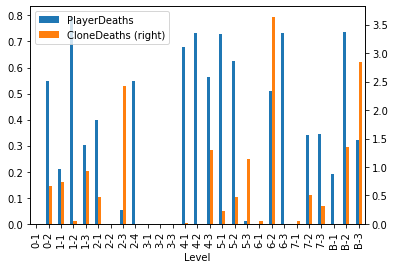

In [101]:
# Average player and clone deaths per level
deathsAvgLevel=df.groupby(by=["Level"]).aggregate({"PlayerDeaths":"mean", "CloneDeaths":"mean"})
deathsAvgLeveldf = deathsAvgLevel.reset_index()

# deathsAvgLeveldf.plot(x = 'level', y = 'playerDeaths', kind = 'barh')
deathsAvgLeveldf.plot(x = 'Level', secondary_y = 'CloneDeaths', kind = 'bar')

# Average Time taken per level

<AxesSubplot: xlabel='Level'>

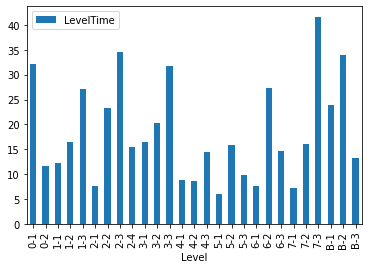

In [102]:
# Average player deaths per level
levelTimeAvgLevel=df.groupby(by=["Level"]).aggregate({"LevelTime":"mean"})
levelTimeAvgLeveldf = levelTimeAvgLevel.reset_index()

levelTimeAvgLeveldf.plot(x = 'Level', y = 'LevelTime', kind = 'bar')

# 1. Unique player attempts vs success rate per level

<AxesSubplot: xlabel='Level', ylabel='Number of Unique Players'>

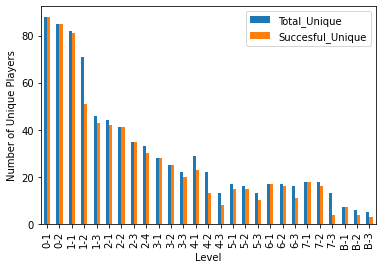

In [103]:
successAttempts = df[(df['PlayerDeaths'] == 0) & (df['Restarts'] == 0)]
failAttempts = df[(df['PlayerDeaths'] != 0) | (df['Restarts'] != 0)]
df1 = successAttempts.groupby(['Level']).aggregate({"GUID": lambda x: x.nunique()}).reset_index()
df2 = df.groupby(['Level']).aggregate({"GUID": lambda x: x.nunique()}).reset_index()
df3 = pd.merge(df1, df2, on='Level')
df3.columns = ['Level', 'Succesful_Unique', 'Total_Unique']
df3["Percentage_Succes"] = (df3['Succesful_Unique'] / df3['Total_Unique']) * 100
df3['Percentage_Succes'] = df3['Percentage_Succes'].apply(lambda x: float("{:.2f}".format(x)))
df3.plot(x = 'Level', y = ['Total_Unique', 'Succesful_Unique'], ylabel = "Number of Unique Players", kind = 'bar')


## Total Unique Players for the Game

In [105]:
u = len(pd.unique(df['GUID']))
print("Total Unique Players for the Game: ", u)

Total Unique Players for the Game:  98


## Level Count per unique player

array([[<AxesSubplot: title={'center': 'Level'}>]], dtype=object)

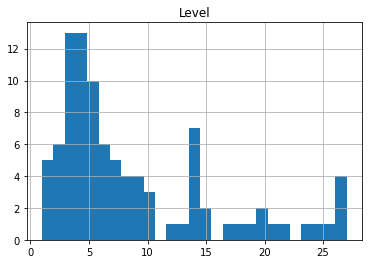

In [86]:
levelProgress = df.groupby(['GUID']).aggregate({'Level': lambda x: x.nunique()}).reset_index()
levelProgress.hist(bins = 27)

In [108]:
allLevels = len(levelProgress[levelProgress['Level'] == 27])
print("Number of players who have played all the levels: ", allLevels)

Number of players who have played all the levels:  4


<AxesSubplot: xlabel='Level', ylabel='Percentage of Succesful Completion'>

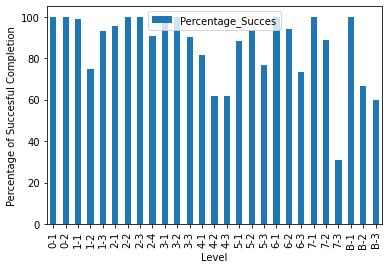

In [48]:
df3.plot(x = 'Level', y = 'Percentage_Succes', ylabel = "Percentage of Succesful Completion", kind = 'bar')

# 2. Time per attempt of every level

Text(0.5, 0, 'Levels')

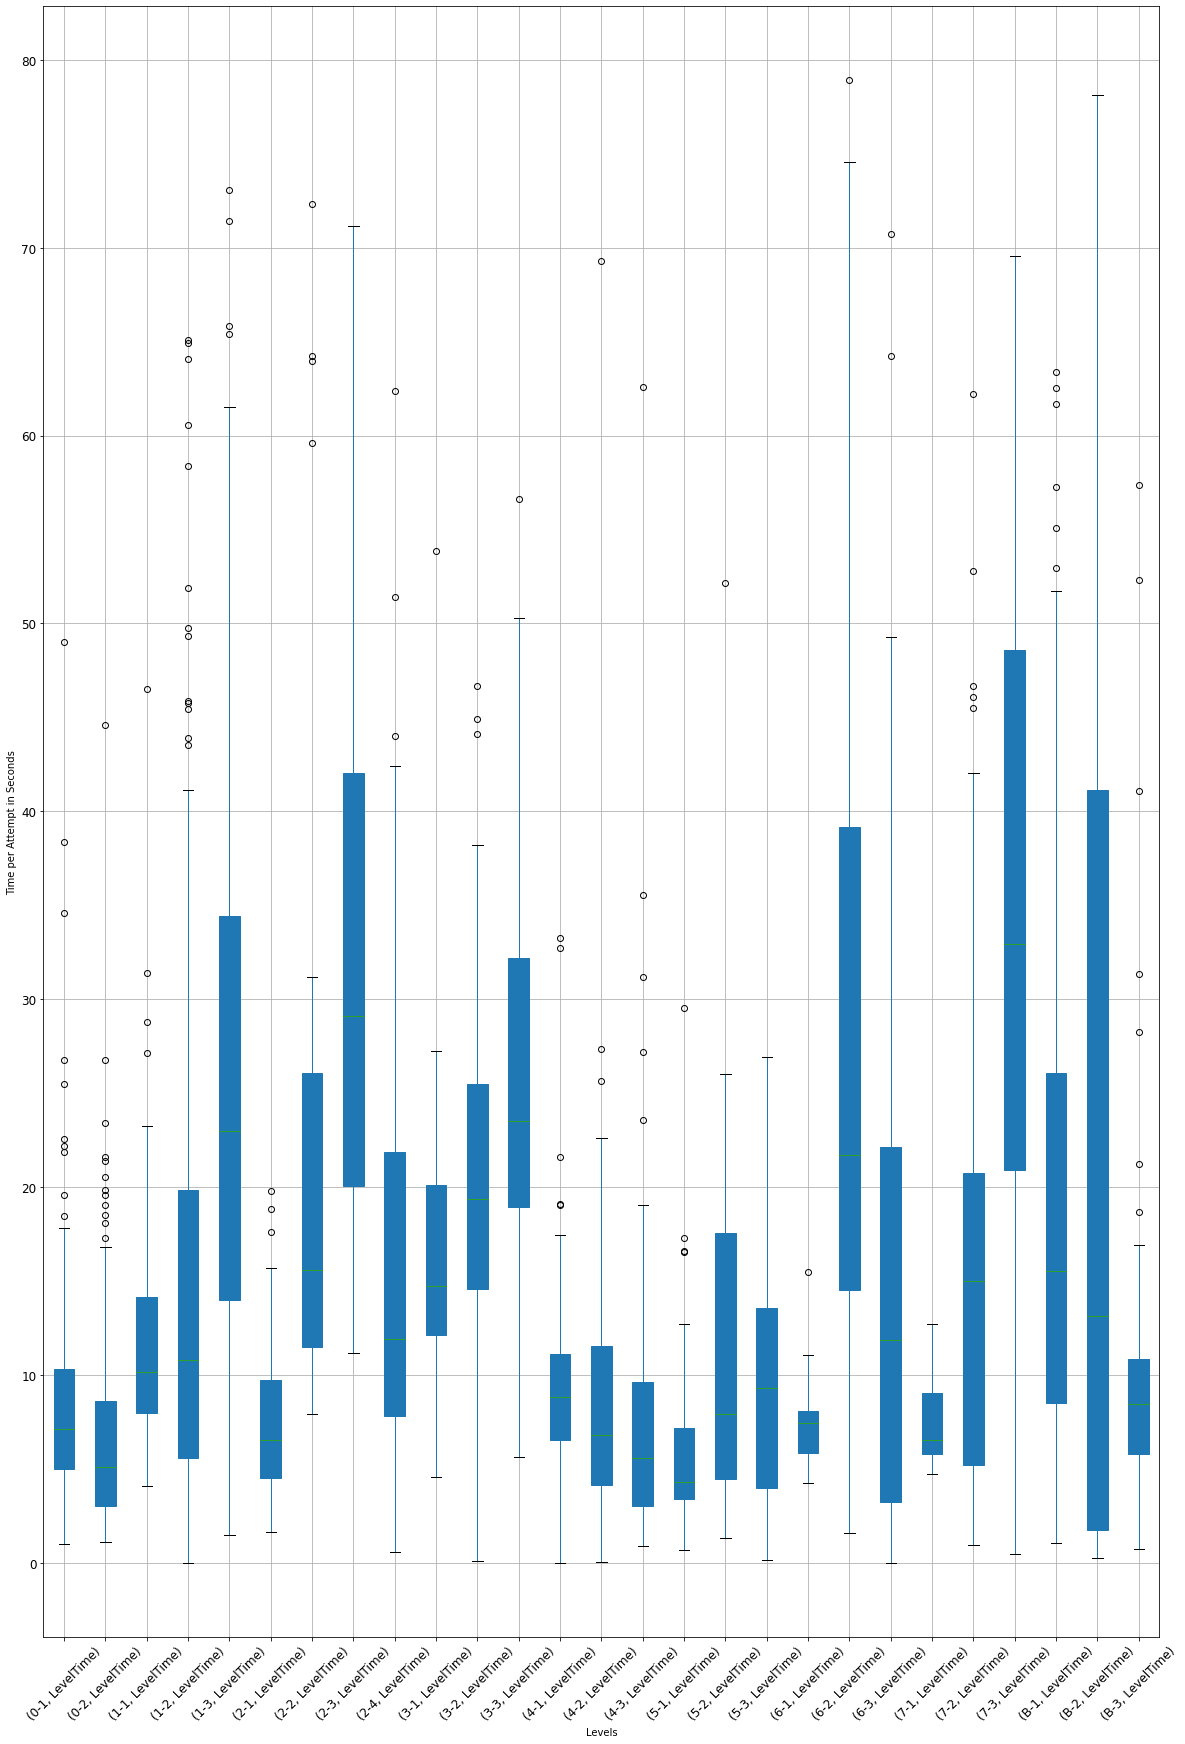

In [49]:
# clip values greater than 80
# remove top x% after review
timedf = df[df['LevelTime']<=80]
bplot = timedf.groupby("Level").boxplot(column = "LevelTime", rot=45, fontsize=12, figsize=(20,30), subplots = "False", patch_artist=True)
bplot.set_ylabel('Time per Attempt in Seconds')
bplot.set_xlabel('Levels')


# 2.2 Attempts per level

### 2.2.1 Total Attempts per Level

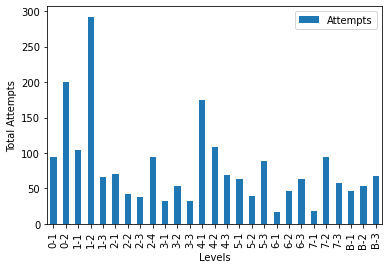

In [139]:
# playerAttemptsLevel = df.groupby(["GUID", "Level"]).aggregate({"PlayerDeaths":"sum", "Restarts":"sum"}).reset_index()
playerAttemptsLevel = df.groupby(["GUID", "Level"]).aggregate({"ApplicationVersion": "count"}).reset_index()
playerAttemptsLevelTot = playerAttemptsLevel.groupby(["Level"]).aggregate({"ApplicationVersion" : "sum"}).reset_index()
playerAttemptsLevelTot.plot(x = 'Level', xlabel = 'Levels', y = 'ApplicationVersion', ylabel = 'Total Attempts', kind = 'bar')
plt.legend(["Attempts"])


### 2.2.2 Average Attempts per Level

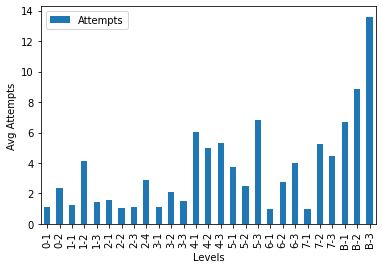

In [140]:
playerAttemptsLevelAvg = playerAttemptsLevel.groupby(["Level"]).aggregate({"ApplicationVersion" : "mean"}).reset_index()
playerAttemptsLevelAvg.plot(x = 'Level', xlabel = 'Levels', y = 'ApplicationVersion', ylabel = 'Avg Attempts', kind = 'bar')
plt.legend(["Attempts"])


# 3. Average Clone Deaths vs success per Level

<AxesSubplot: xlabel='Levels', ylabel='Avg Clone Deaths'>

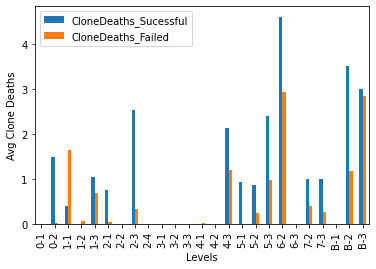

In [51]:
cloneAttemptsSuccessful=successAttempts.groupby(by=["Level"]).aggregate({"CloneDeaths":"mean"})
cloneAttemptsSuccessful = cloneAttemptsSuccessful.reset_index()
cloneAttemptsSuccessful
cloneAttemptsFailure = failAttempts.groupby(by=["Level"]).aggregate({"CloneDeaths":"mean"})
cloneAttemptsFailure = cloneAttemptsFailure.reset_index()
cloneAttemptsFailure

cloneStats = pd.merge(cloneAttemptsSuccessful, cloneAttemptsFailure, on='Level')
cloneStats.columns = ['Levels', 'CloneDeaths_Sucessful', 'CloneDeaths_Failed']
cloneStats.plot(x = 'Levels', ylabel = "Avg Clone Deaths", y = ['CloneDeaths_Sucessful', 'CloneDeaths_Failed'], kind = 'bar')


# Metric 4: Detailed death analysis for Levels

In [52]:
causeDeath = {'Spike': 'red', 'MovingSpike': 'green', 'KillZone': 'blue'}

In [53]:
deathPos = df[['Level', 'PlayerDeaths', 'causeOfDeathPlayer', 'postionOfDeathPlayer', 'CameraHeight', 'CameraWidth']]
deathPos = deathPos.replace('', np.nan)
deathPos = deathPos.dropna()
deathPos['xcoord'] = deathPos['postionOfDeathPlayer'].apply(lambda x: x_coord(x[1:-2]))
deathPos['ycoord'] = deathPos['postionOfDeathPlayer'].apply(lambda x: y_coord(x[1:-2]))
deathPos['color'] = deathPos['causeOfDeathPlayer'].map(causeDeath)


In [54]:
camera = deathPos[['Level', 'CameraHeight', 'CameraWidth']]
cameradf = camera.groupby('Level').last().reset_index()
cameradf.loc[cameradf['Level'].isin(fourseries), 'CameraHeight'] = 15.00


<AxesSubplot: xlabel='Level', ylabel='Total Player Deaths'>

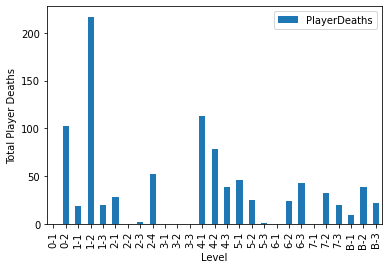

In [72]:
playerDeathPos = df.groupby(by=["Level"]).aggregate({"PlayerDeaths":"sum"}).reset_index()
playerDeathPos
playerDeathPos.plot(x = 'Level', y = 'PlayerDeaths', ylabel = "Total Player Deaths", kind = 'bar')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


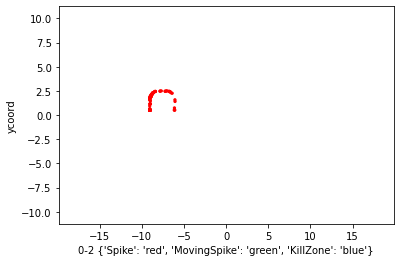

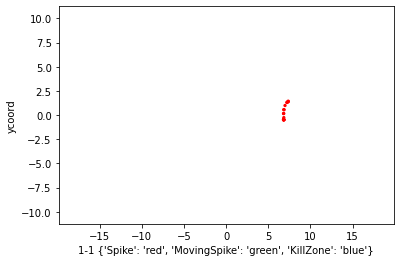

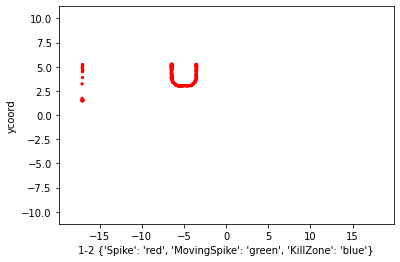

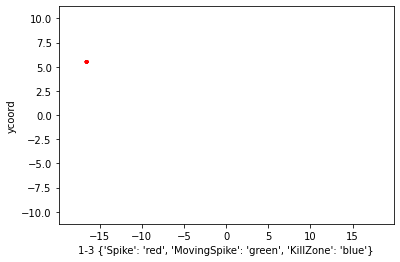

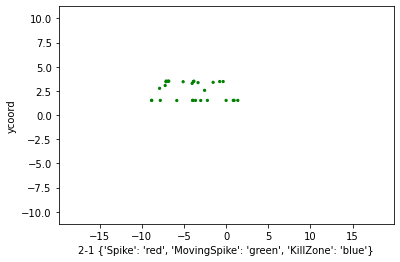

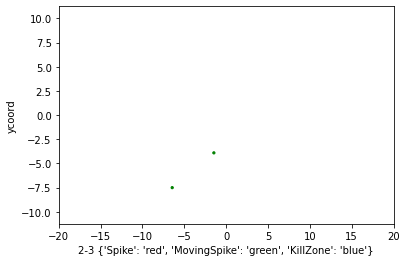

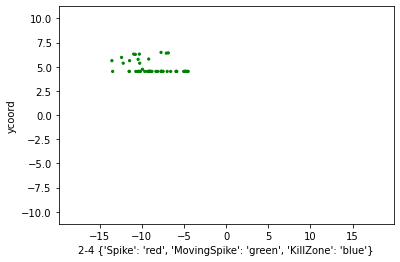

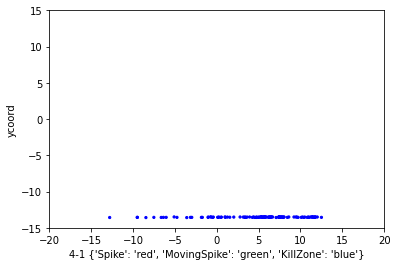

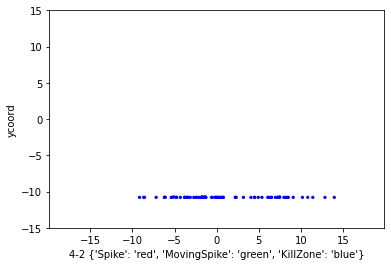

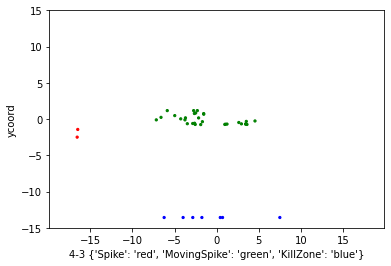

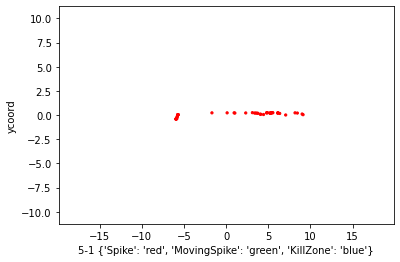

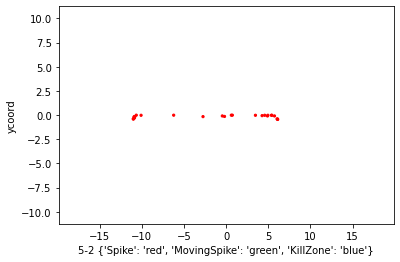

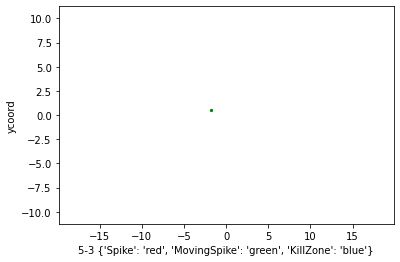

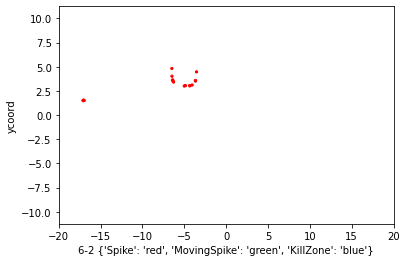

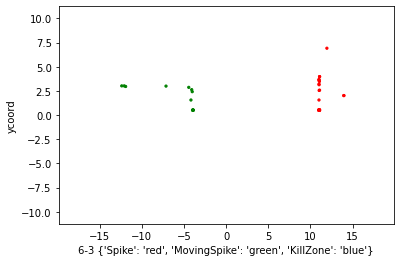

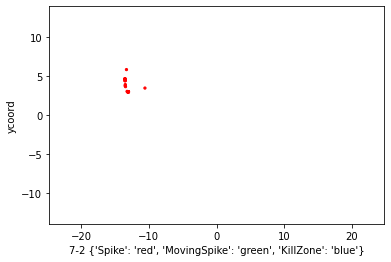

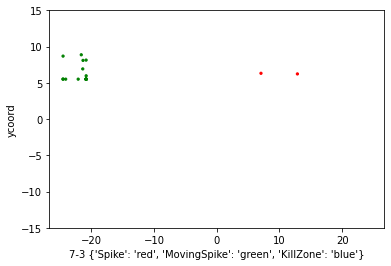

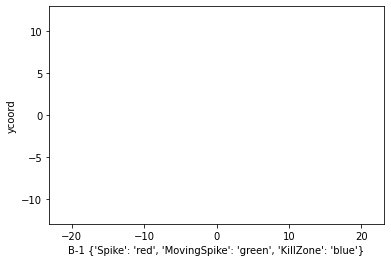

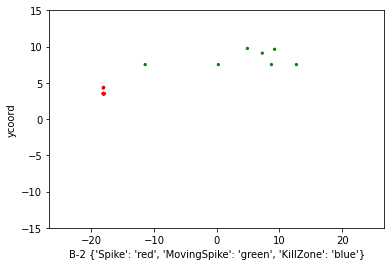

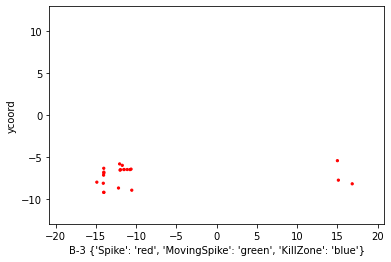

In [57]:
for index, row in cameradf.iterrows():
    deathPos[deathPos['Level'].eq(row['Level'])].plot.scatter(xlabel = row['Level'] + ' ' + str(causeDeath), 
                                                              x = 'xcoord', 
                                                              y = 'ycoord', 
                                                              s = 5, 
                                                              xlim = (-row['CameraWidth'] , row['CameraWidth']), 
                                                              ylim = (-row['CameraHeight'] , row['CameraHeight']), 
                                                              c = 'color'
                                                            
                                                             )
    
    

# 5. Gem Metrics

## 5.1 %age of attempts that collected gems in Levels containing them

<AxesSubplot: xlabel='Level', ylabel='% Attempts that have collected Gems'>

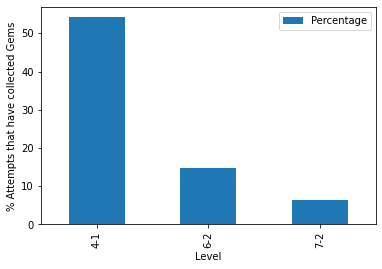

In [58]:
gemAttempts = df[(df['collectedGem'] == 'TRUE') & (df['Level'].isin(gemLevels))]
gemLevels = df[(df['Level'].isin(gemLevels))]
gemCount = gemLevels.groupby(by=['Level']).aggregate({'collectedGem':'count'}).reset_index()
gemTrue = gemAttempts.groupby(by=['Level']).aggregate({'collectedGem':'count'}).reset_index()

gemdf = pd.merge(gemTrue, gemCount, on='Level')
gemdf["Percentage"] = round((gemdf['collectedGem_x']/gemdf['collectedGem_y']) * 100, 2)
gemdf.plot(x = 'Level', ylabel = "% Attempts that have collected Gems", y = 'Percentage', kind = 'bar')



## 5.2 %age of succesful attempts that collected gems

,Level,collectedGem_x,collectedGem_y,Percentage
2,7-2,5,6,83.33


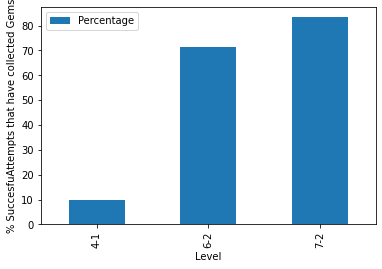

In [121]:
gemSuccessfulAttempts = gemAttempts[(gemAttempts['PlayerDeaths'] == 0) & (gemAttempts['Restarts'] == 0)]
gemSuccessCount = gemSuccessfulAttempts.groupby(by=['Level']).aggregate({'collectedGem':'count'}).reset_index()

gemdf1 = pd.merge(gemSuccessCount, gemTrue, on = 'Level')
gemdf1["Percentage"] = round((gemdf1['collectedGem_x']/gemdf1['collectedGem_y']) * 100, 2)
gemdf1.plot(x = 'Level', ylabel = "% SuccesfuAttempts that have collected Gems", y = 'Percentage', kind = 'bar')
gemdf1[gemdf1['Level'].eq('7-2')]

# Pill Metrics

## 6.1 % of succesfull attempts for pill vs non-pill levels

<AxesSubplot: xlabel='Level Categories', ylabel='% Successful Attempts'>

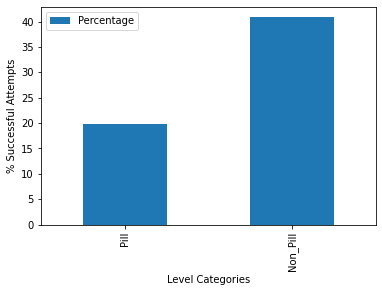

In [117]:
pillSuccessAttempts = df[(df['PlayerDeaths'] == 0) & (df['Restarts'] == 0) & (df['collectedPill'] == 'TRUE') & (df['Level'].isin(pillLevels))]
pillAttempts = df[(df['Level'].isin(pillLevels))]

pillSuccessCount = pillSuccessAttempts.groupby(by=['Level']).aggregate({'collectedPill':'count'}).reset_index()
pillAttemptsCount = pillAttempts.groupby(by=['Level']).aggregate({'collectedPill':'count'}).reset_index()

psum1 = pillSuccessCount['collectedPill'].sum()
psum2 = pillAttemptsCount['collectedPill'].sum()
pp = round((psum1/psum2) * 100, 2)
pilldf = pd.DataFrame(columns = ['x','Percentage'])
pilldf.loc[len(pilldf)] = ['Pill', pp]

successAttemptsNonPill = successAttempts[~(successAttempts['Level'].isin(pillLevels))]
totalAttemptsNonPill = df[~(df['Level'].isin(pillLevels))]
successAttemptsCount = successAttemptsNonPill.groupby(by=['Level']).size().rename('Succesful_Attempts').reset_index()
totalAttemptsCount = totalAttemptsNonPill.groupby(by=['Level']).size().rename('Total_Attempts').reset_index()

npsum1 = successAttemptsCount['Succesful_Attempts'].sum()
npsum2 = totalAttemptsCount['Total_Attempts'].sum()
npp = round((npsum1/npsum2) * 100, 2)
pilldf.loc[len(pilldf)] = ['Non_Pill', npp]

pilldf.plot(x = 'x', xlabel = "Level Categories", ylabel = "% Successful Attempts", y = 'Percentage', kind = 'bar')


## 6.2 % of succesful attempts per pill level

<AxesSubplot: xlabel='Level', ylabel='% Succesful Attempts with Pills'>

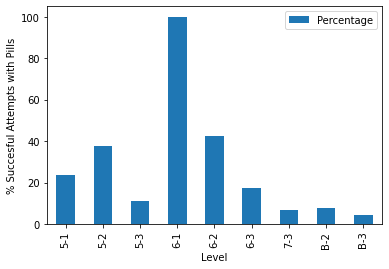

In [120]:
pillSuccessCount["Percentage"] = round((pillSuccessCount['collectedPill']/pillAttemptsCount['collectedPill']) * 100, 2)
pillSuccessCount.plot(x = 'Level', ylabel = "% Succesful Attempts with Pills", y = 'Percentage', kind = 'bar')
